In [1]:
#pacotes
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
from tabulate import tabulate
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.tsa.statespace.sarimax as sarimax
import os
import pandas as pd
import math
import numpy as np
from statsmodels.tsa.x13 import x13_arima_analysis
register_matplotlib_converters()

diretorio = os.path.dirname(os.getcwd())


In [2]:
# Nome da Planilha com os dados da Argentina usados no artigo original = "default_data".
local_arquivo = os.path.join(diretorio,
                             'dados',
                             'default_data.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo)

#Inserindo Index trimestral
dataframe.index = pd.date_range('1980-03',
                      periods=len(dataframe['Y_REAL']),
                      freq='Q')
#Remover Coluna
dataframe = dataframe.drop(columns=["Unnamed: 0"])

In [3]:
# Ajuste Sazonal
local_x13_seassonal_file = os.path.join(diretorio,
                                        'notebook',
                                        'x13',
                                        'x13as')

dataframe['Y_Real_Des'] = x13_arima_analysis(dataframe['Y_REAL'],x12path=local_x13_seassonal_file).seasadj.values

In [4]:
# Log das variaveis reais dessasonalizadas
dataframe['C_REAL'] = np.log(dataframe['C_REAL'])
dataframe['Y_REAL'] = np.log(dataframe['Y_REAL'])
dataframe['Y_Real_Des'] = np.log(dataframe['Y_Real_Des'])

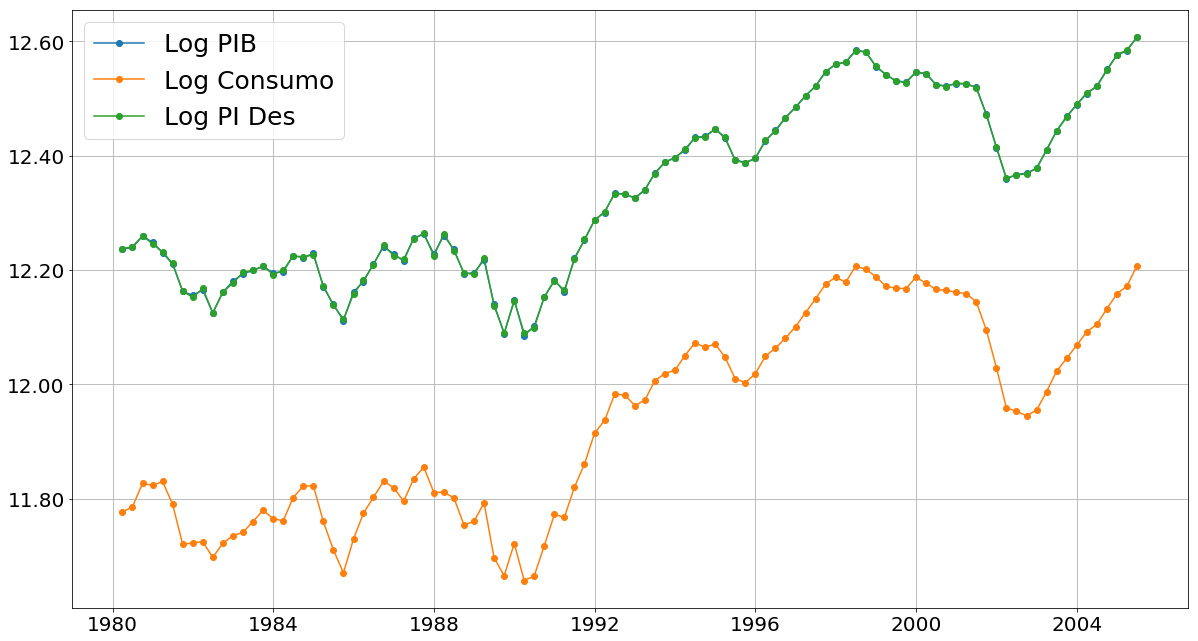

In [5]:
# Plot do Log das Series
fmt = '{x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)


#Iniciando os gráfico e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


# Plot da Serie Com Ajuste 
ax.yaxis.set_major_formatter(tick) 
ax.plot(dataframe.index,
        dataframe['Y_REAL'].values,'-o',label='Log PIB',)


# Plot da Serie Com Consumo
ax.yaxis.set_major_formatter(tick) 
ax.plot(dataframe.index,
        dataframe['C_REAL'].values,'-o',label='Log Consumo')


# Plot da Serie Com Ajuste Sazonal
ax.yaxis.set_major_formatter(tick) 
ax.plot(dataframe.index,
        dataframe['Y_Real_Des'].values,'-o',label='Log PI Des')


# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legendas
ax.legend(loc="upper left",fontsize=25)

In [6]:
# Filtro de Tendência
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
dataframe['y_real_detrend'] = signal.detrend(dataframe['Y_REAL'])
dataframe['c_real_detrend'] = signal.detrend(dataframe['C_REAL'])
dataframe['Y_Real_Des_detrend'] = signal.detrend(dataframe['Y_Real_Des'])

y_real_detrend = signal.detrend(dataframe['Y_REAL'])
c_real_detrend = signal.detrend(dataframe['C_REAL'])
Y_Real_Des_detrend = signal.detrend(dataframe['Y_Real_Des'])

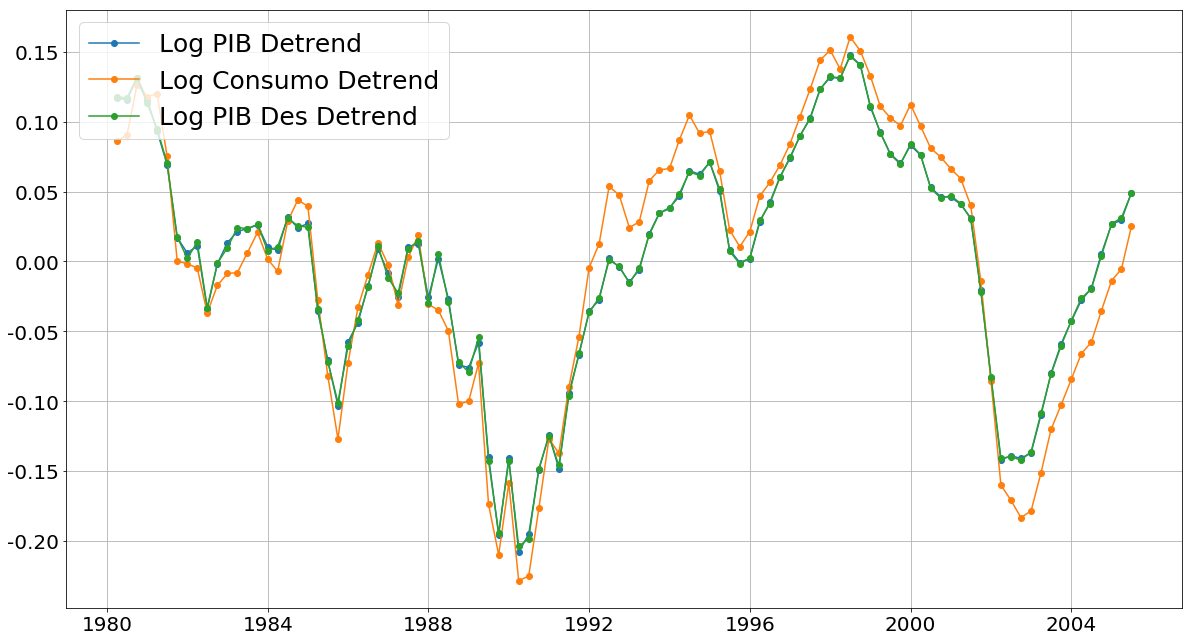

In [7]:
#Iniciando os gráficos e fazendo configurações globais
fig, ax = plt.subplots(figsize=(20,11))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


# Plot da Serie Com Ajuste Sazonal
ax.yaxis.set_major_formatter(tick) 
ax.plot(dataframe.index,
        y_real_detrend,'-o',label='Log PIB Detrend')


# Plot da Serie Com Ajuste Sazonal Consump
ax.yaxis.set_major_formatter(tick) 
ax.plot(dataframe.index,
        c_real_detrend,'-o',label='Log Consumo Detrend')

# Plot da Serie Com Ajuste Sazonal
ax.yaxis.set_major_formatter(tick) 
ax.plot(dataframe.index,
        Y_Real_Des_detrend,'-o',label='Log PIB Des Detrend')

# Adicionando linhas verticais e horizontais
ax.grid(True)

# Adicionando as legendas
ax.legend(loc="upper left",fontsize=25)

In [8]:
# AR1 Sarimax
regressao  = sarimax.SARIMAX(y_real_detrend,order=(1,0,0),trend='n').fit()
print({'coef':regressao.params[0],
       'Std': regressao.bse[0]})

{'coef': 0.9341043616815882, 'Std': 0.031631341952259036}


In [9]:
# AR1 Pacote Alternativo
import statsmodels.tsa.ar_model as ar_model
regressao  = ar_model.AR(Y_Real_Des_detrend).fit(maxlag=1,trend='nc')
print({'coef':regressao.params[0],
       'Std': regressao.bse[0]})

{'coef': 0.9343371916611759, 'Std': 0.03310820512777191}


/home/frederico/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, Future

In [10]:
# Tabela de Correlações
dataframe[['y_real_detrend',
           'c_real_detrend',
           'TB_Y',
           'SPREAD']].corr()

,y_real_detrend,c_real_detrend,TB_Y,SPREAD
y_real_detrend,1.000000,0.973005,-0.854268,-0.700106
c_real_detrend,0.973005,1.000000,-0.929440,-0.742450
TB_Y,-0.854268,-0.929440,1.000000,0.954936
SPREAD,-0.700106,-0.742450,0.954936,1.000000


In [11]:
# Tabela com as Médias de Cadas série
dataframe[['y_real_detrend',
           'c_real_detrend',
           'TB_Y',
           'SPREAD']].describe()

,y_real_detrend,c_real_detrend,TB_Y,SPREAD
count,1.020000e+02,1.020000e+02,50.000000,80.000000
mean,3.813943e-15,1.114577e-15,0.018325,12.812918
std,8.100524e-02,9.515848e-02,0.057991,11.794916
min,-2.079025e-01,-2.284951e-01,-0.047177,1.115208
25%,-4.098558e-02,-5.681344e-02,-0.023609,6.190873
50%,9.591371e-03,8.398497e-03,-0.008505,9.904622
75%,5.008111e-02,7.329369e-02,0.056885,14.142708
max,1.475959e-01,1.607005e-01,0.171272,64.740000


In [12]:
# Parametros e Targets do Artigo

arellano2008 = {
    "calibrar":{"β":0.953,
                "θ":0.289,
                "ydefcost":0.969},
    
    "parametros":{"ρ":0.945,
                  "η":0.025,
                  "γ":2,
                  "r":0.017
                  },
    
    "targets":{"corr_pip_consumo":0.98,
               "corr_pip_spread":-0.88,
               "corr_pip_tb":-0.64,
               "corr_spread_tb":0.7,
               "def_prob_emp":0.03,
               "trade_balance_vol":1.75,
               "debt_service_to_gdp":0.969}
               }


In [13]:
# Pacote para Otimização
from scipy.optimize import minimize

In [21]:
# Fun

import sys
sys.path.append('..')

from python.arellano_model import Arellano_Economy
from python.arellano_graficos import simulacao
import importlib
import python.arellano_graficos

importlib.reload(python.arellano_graficos)

def funcao_otimizar(x,*args):
    print(x)
    Economia_Arellano = Arellano_Economy(
        β = x[0],# time discount rate
        θ = x[1],# prob of regaining access
        ydefcost = x[2], # default cost
                                     
        γ = arellano2008["parametros"]["γ"],# risk aversion
        r = arellano2008["parametros"]["r"],# international interest rate
        ρ = arellano2008["parametros"]["ρ"],# persistence in output
        η = arellano2008["parametros"]["η"],# st dev of output shock
        
        ny = 21,         # number of points in y grid
        nB = 251,        # number of points in B grid
        tol = 1e-8,      # error tolerance in iteration
        maxit = 10000,
                                     )
    
    estatisticas_simuladas_1 = simulacao(Economia_Arellano)['simulacao_1']
    corrSimuSpreadPIB = round(estatisticas_simuladas_1['corr(x,y)'][0],4)
    corrSimuPibBC = round(estatisticas_simuladas_1['corr(x,y)'][1],4)
    corrSimuSpreadBC = round(estatisticas_simuladas_1['corr(x,r-spread)'][1],4)
    corrSimuPibConsu = round(estatisticas_simuladas_1['corr(x,y)'][2],4)
    
    targetdebtService = round(simulacao(Economia_Arellano)['simulacao_2']['valor'][0],4)
    targetMeanTB = round(simulacao(Economia_Arellano)['simulacao_2']['valor'][1],4)
    targetDefProb = round(simulacao(Economia_Arellano)['simulacao_2']['valor'][2],4)
    
    valorObjetivo = ((arellano2008["targets"]["def_prob_emp"] - targetDefProb)**2 + (arellano2008["targets"]["trade_balance_vol"] - targetMeanTB)**2 + (arellano2008["targets"]["debt_service_to_gdp"] - targetdebtService)**2 + (arellano2008["targets"]["corr_pip_tb"] - corrSimuPibBC)**2 + (arellano2008["targets"]["corr_spread_tb"]  - corrSimuSpreadBC)**2 + (arellano2008["targets"]["corr_pip_spread"]  - corrSimuSpreadPIB)**2 + (arellano2008["targets"]["corr_pip_consumo"]  - corrSimuPibConsu)**2)**(1/2)
    return valorObjetivo

In [36]:
bnds = ((0.5, 0.999), (0, 1), (0.87,0.99))
res = minimize(funcao_otimizar,[0.90,0.4,0.90],bounds=bnds)

[0.9 0.4 0.9]
Running iteration 25 with dist of 0.09418815334931097
Running iteration 50 with dist of 0.006203862764516899
Running iteration 75 with dist of 0.0004364447218101475
Running iteration 100 with dist of 3.118005141899971e-05
Running iteration 125 with dist of 2.2357663524985583e-06
Running iteration 150 with dist of 1.6045914463802546e-07
Running iteration 175 with dist of 1.151853190606289e-08
[0.90000001 0.4        0.9       ]
Running iteration 25 with dist of 0.09418817748364461
Running iteration 50 with dist of 0.006203866095097155
Running iteration 75 with dist of 0.00043644507760021156
Running iteration 100 with dist of 3.118008550018203e-05
Running iteration 125 with dist of 2.235769418490463e-06
Running iteration 150 with dist of 1.604594075388377e-07
Running iteration 175 with dist of 1.1518553222344963e-08
[0.9        0.40000001 0.9       ]
Running iteration 25 with dist of 0.09418815334396058
Running iteration 50 with dist of 0.00620386276410656
Running iteration 

Running iteration 175 with dist of 1.0173957676329337e-08
[0.89935609 0.40096589 0.89995171]
Running iteration 25 with dist of 0.09264798147553677
Running iteration 50 with dist of 0.005992706658988212
Running iteration 75 with dist of 0.00041410205483138895
Running iteration 100 with dist of 2.9059156945621112e-05
Running iteration 125 with dist of 2.0467352843667186e-06
Running iteration 150 with dist of 1.4428757211248922e-07
Running iteration 175 with dist of 1.017397721625457e-08
[0.89935608 0.4009659  0.89995171]
Running iteration 25 with dist of 0.09264795771836987
Running iteration 50 with dist of 0.005992703439389402
Running iteration 75 with dist of 0.0004141017170180561
Running iteration 100 with dist of 2.905912516304454e-05
Running iteration 125 with dist of 2.0467324741701987e-06
Running iteration 150 with dist of 1.4428733408067274e-07
Running iteration 175 with dist of 1.0173957676329337e-08
[0.89935608 0.40096589 0.89995172]
Running iteration 25 with dist of 0.09264795

Running iteration 25 with dist of 0.09418292574093812
Running iteration 50 with dist of 0.006203141523675626
Running iteration 75 with dist of 0.00043636767966503953
Running iteration 100 with dist of 3.117267137042745e-05
Running iteration 125 with dist of 2.235102696701574e-06
Running iteration 150 with dist of 1.6040186423538216e-07
Running iteration 175 with dist of 1.1513726860812312e-08
[0.89999784 0.40000325 0.89999984]
Running iteration 25 with dist of 0.09418294987396791
Running iteration 50 with dist of 0.006203144853873965
Running iteration 75 with dist of 0.00043636803539115476
Running iteration 100 with dist of 3.1172705449833416e-05
Running iteration 125 with dist of 2.235105760917122e-06
Running iteration 150 with dist of 1.6040213068890807e-07
Running iteration 175 with dist of 1.1513748177094385e-08
[0.89999783 0.40000326 0.89999984]
Running iteration 25 with dist of 0.09418292573558595
Running iteration 50 with dist of 0.0062031415232652876
Running iteration 75 with d

Running iteration 50 with dist of 0.0062031152883808005
Running iteration 75 with dist of 0.0004363648769754036
Running iteration 100 with dist of 3.117240288297296e-05
Running iteration 125 with dist of 2.235078550683056e-06
Running iteration 150 with dist of 1.6039978234516639e-07
Running iteration 175 with dist of 1.1513552777842051e-08
[0.89999782 0.40000326 0.89999983]
Running iteration 25 with dist of 0.09418288774152828
Running iteration 50 with dist of 0.0062031362821972635
Running iteration 75 with dist of 0.00043636711967920405
Running iteration 100 with dist of 3.11726177244509e-05
Running iteration 125 with dist of 2.235097873892755e-06
Running iteration 150 with dist of 1.6040144856788174e-07
Running iteration 175 with dist of 1.1513691333675524e-08
[0.89999783 0.40000326 0.89999983]
Running iteration 25 with dist of 0.09418291187455807
Running iteration 50 with dist of 0.00620313961239205
Running iteration 75 with dist of 0.000436367475408872
Running iteration 100 with di

Running iteration 75 with dist of 0.0004363676796366178
Running iteration 100 with dist of 3.1172671368651095e-05
Running iteration 125 with dist of 2.235102698477931e-06
Running iteration 150 with dist of 1.6040186778809584e-07
Running iteration 175 with dist of 1.1513725084455473e-08
[0.89999783 0.40000325 0.89999985]
Running iteration 25 with dist of 0.09418292571430698
Running iteration 50 with dist of 0.0062031415169627735
Running iteration 75 with dist of 0.00043636767914634333
Running iteration 100 with dist of 3.117267133312396e-05
Running iteration 125 with dist of 2.2351026931488605e-06
Running iteration 150 with dist of 1.60401866011739e-07
Running iteration 175 with dist of 1.1513730413525991e-08
[0.89999783 0.40000325 0.89999984]
Running iteration 25 with dist of 0.09418292574093812
Running iteration 50 with dist of 0.006203141523675626
Running iteration 75 with dist of 0.00043636767966503953
Running iteration 100 with dist of 3.117267137042745e-05
Running iteration 125 wi

In [35]:
res

      fun: 1.7027860288362715
 hess_inv: array([[ 2.07139429e-14, -2.03946151e-15, -1.39399385e-14],
       [-1.45165165e-15,  1.67784533e-15,  2.69276914e-16],
       [-1.45383587e-14,  6.83066523e-16,  1.04671775e-14]])
      jac: array([1391494.00633459, 1426390.75492398, 2157754.04672776])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 197
      nit: 4
     njev: 35
   status: 2
  success: False
        x: array([0.89996301, 0.39997467, 0.8999758 ])